# Custom ResNet-34 with Dropout on CIFAR-10 Dataset

Importing the required Python libraries

In [1]:
import math
import os
import sys
import time

import torch
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset Preparation

We download the CIFAR-10 train and test datasets from torchvision. The datasets are normalized and transformations applied. Additionally, for the training dataset, we will apply Random Crops and Random Horizontal Flips to improve model generalization.

In [2]:
# Mean, Standard Deviation of CIFAR-10 dataset channels
data_stats = (
    (0.49139968, 0.48215827, 0.44653124),
    (0.24703233, 0.24348505, 0.26158768)
)

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # Random crops
    transforms.RandomHorizontalFlip(), # Random horizontal flips
    transforms.ToTensor(), # Channel x Image Height x Image Width
    transforms.Normalize(*data_stats, inplace=True) # Output in range [-1, 1]
])

val_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*data_stats, inplace=True)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_stats, inplace=True)
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=False, transform=test_transforms)

100%|██████████| 170M/170M [00:02<00:00, 75.9MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


Now we create data loaders to retrieve images in batches. The batch size for the training loader is set to 128 images, while for the test loader, we choose a batch size of 100 images. Additionally, we will use a batch size of 100 images for the validation set as well. The training and validation split is 80-20.

In [4]:
validation_ratio = 0.2
train_size = int((1 - validation_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [5]:
train_batch_size = 128
test_batch_size = 100
val_batch_size = 100

train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_dataset, test_batch_size, shuffle=False, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_dataset, val_batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The following functions are to display a batch of images from the dataset, and to denormalize the pixels values to bring them back into the range (0,1) in order to visualize the images.

In [6]:
def visualize_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(images, *data_stats)
    ax.imshow(make_grid(denorm_images[:64], 8).permute(1, 2, 0))
    break

In [7]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

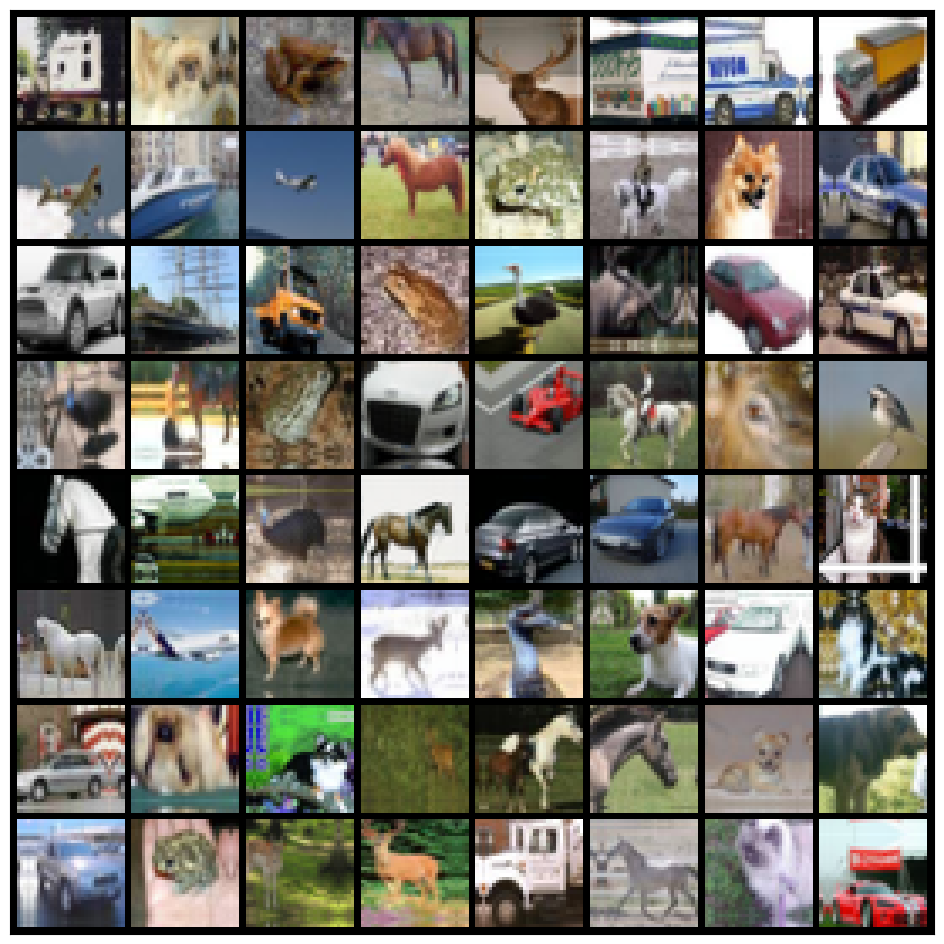

In [8]:
visualize_batch(train_dl)

The following are helper functions to set the device to GPU/CPU depending on availability, and move the model to GPU.

In [9]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


# Move tensors to chosen device
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)


# Wrap a dataloader to move data to a device
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  # Number of batches
  def __len__(self):
    return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### ResNet Architecture

We have added a dropout layer for regularization and reduced the channel sizes to contain the number of parameters of the model.

In [12]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.dropout = nn.Dropout(0.2) # Adding Dropout Layer

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.dropout(self.bn2(self.conv2(out))) # Adding Dropout in Forward
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 96, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 192, num_blocks[3], stride=2)
    self.linear = nn.Linear(192*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

### ResNet34

In [13]:
model = ResNet34()

In [14]:
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [15]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
           Dropout-7           [-1, 64, 32, 32]               0
        BasicBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
          Dropout-13           [-1, 64, 32, 32]               0
       BasicBlock-14           [-1, 64,

## Model Training

* Number of Epochs: 100
* Learning Rate: 0.1
* Scheduler: CosineAnnealingLR
* Momentum: 0.9
* Weight Decay: 5e-4
* Loss: CrossEntropyLoss
* Optimizer: SGD

In [16]:
lr = 0.1
momentum = 0.9
weight_decay = 5e-4

start_epoch = 1
number_of_epochs = 100
best_test_acc = 0
best_val_acc = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=number_of_epochs)

In [17]:
# Helper function to get Learning Rate
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [18]:
def train(epoch):
  print('\nEpoch: %d' % epoch)

  model.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(train_dl):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

    avg_train_loss = train_loss / (batch_idx + 1)
    train_acc = 100. * correct / total

  return avg_train_loss, train_acc, get_lr(optimizer)

In [19]:
def validate(epoch):

  global best_val_acc

  model.eval()
  val_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(val_dl):
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          val_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()

  # Save checkpoint
  val_acc = 100. * correct / total
  if val_acc > best_val_acc:
    print('Saving checkpoint...')
    state = {
      'net': model.state_dict(),
      'acc': val_acc,
      'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
    torch.save(state, './checkpoint/rn_34_best.pth')
    best_val_acc = val_acc

  avg_val_loss = val_loss / (batch_idx + 1)

  return avg_val_loss, val_acc

In [20]:
def test(epoch):

  global best_test_acc

  model.eval()
  test_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dl):
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  acc = 100. * correct / total
  if acc > best_test_acc:
    best_test_acc = acc

  avg_test_loss = test_loss / (batch_idx + 1)

  return avg_test_loss, acc

In [21]:
train_losses = []
train_accuracies = []
train_lrs = []

val_losses = []
val_accuracies = []

test_losses = []
test_accuracies = []

for epoch in range(start_epoch, start_epoch + number_of_epochs):
  epoch_train_loss, epoch_train_accuracy, epoch_lr = train(epoch)
  train_losses.append(epoch_train_loss)
  train_accuracies.append(epoch_train_accuracy)
  train_lrs.append(epoch_lr)

  epoch_val_loss, epoch_val_accuracy = validate(epoch)
  val_losses.append(epoch_val_loss)
  val_accuracies.append(epoch_val_accuracy)

  epoch_test_loss, epoch_test_accuracy = test(epoch)
  test_losses.append(epoch_test_loss)
  test_accuracies.append(epoch_test_accuracy)

  scheduler.step() # adjust LR

  print(f"Train Loss: {epoch_train_loss:.3f} | Train Accuracy: {epoch_train_accuracy:.3f}% \n"
        f"Validation Loss: {epoch_val_loss:.3f} | Validation Accuracy: {epoch_val_accuracy:.3f}% \n"
        f"Test Loss: {epoch_test_loss:.3f} | Test Accuracy: {epoch_test_accuracy:.3f}%")


Epoch: 1
Saving checkpoint...
Train Loss: 1.917 | Train Accuracy: 29.398% 
Validation Loss: 1.696 | Validation Accuracy: 36.770% 
Test Loss: 1.642 | Test Accuracy: 38.350%

Epoch: 2
Saving checkpoint...
Train Loss: 1.545 | Train Accuracy: 42.835% 
Validation Loss: 1.445 | Validation Accuracy: 47.170% 
Test Loss: 1.401 | Test Accuracy: 49.180%

Epoch: 3
Saving checkpoint...
Train Loss: 1.328 | Train Accuracy: 51.557% 
Validation Loss: 1.259 | Validation Accuracy: 54.740% 
Test Loss: 1.170 | Test Accuracy: 57.540%

Epoch: 4
Saving checkpoint...
Train Loss: 1.121 | Train Accuracy: 59.720% 
Validation Loss: 1.154 | Validation Accuracy: 59.500% 
Test Loss: 1.098 | Test Accuracy: 61.500%

Epoch: 5
Saving checkpoint...
Train Loss: 0.967 | Train Accuracy: 65.612% 
Validation Loss: 1.024 | Validation Accuracy: 64.380% 
Test Loss: 0.940 | Test Accuracy: 66.870%

Epoch: 6
Saving checkpoint...
Train Loss: 0.839 | Train Accuracy: 70.198% 
Validation Loss: 0.871 | Validation Accuracy: 69.220% 
Test

In [22]:
print(f"Best Validation Accuracy: {best_val_acc:.3f}%")

Best Validation Accuracy: 94.130%


In [23]:
print(f"Best Test Accuracy: {best_test_acc: .3f}%")

Best Test Accuracy:  94.440%


## Visualizations

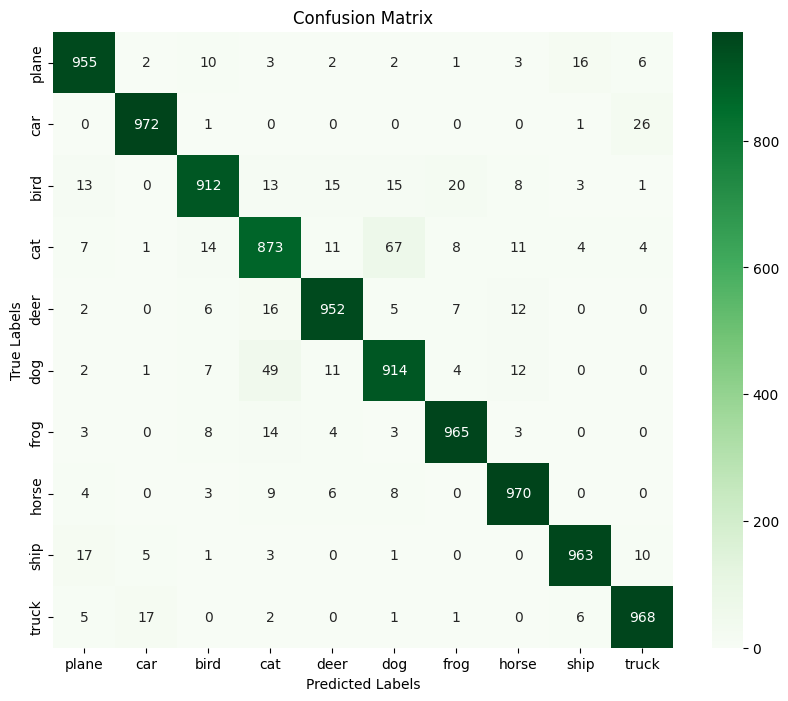

In [24]:
# Evaluate model on test set to generate predictions, calculate confusion matrix, and visualize it

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).tolist())
        y_true.extend(labels.view(-1).tolist())

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
def plot_test_accuracies(train_accuracies, test_accuracies):
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(test_accuracies, label='Test Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.title('Accuracy vs #epochs')

In [44]:
def plot_val_accuracies(train_accuracies, val_accuracies):
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.title('Accuracy vs #epochs')

In [45]:
def plot_test_losses(train_losses, test_losses):
  plt.plot(train_losses, label='Train Losses')
  plt.plot(test_losses, label='Test Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.title('Loss vs #epochs')

In [53]:
def plot_val_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Losses')
    plt.plot(val_losses, label='Validation Losses')  # Added validation loss
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training vs Validation Loss')

In [29]:
def plot_lrs(train_lrs):
  plt.plot(train_lrs)
  plt.xlabel('Epochs')
  plt.ylabel('Learning rate')
  plt.grid(True)
  plt.title('Learning Rate vs. Epochs')

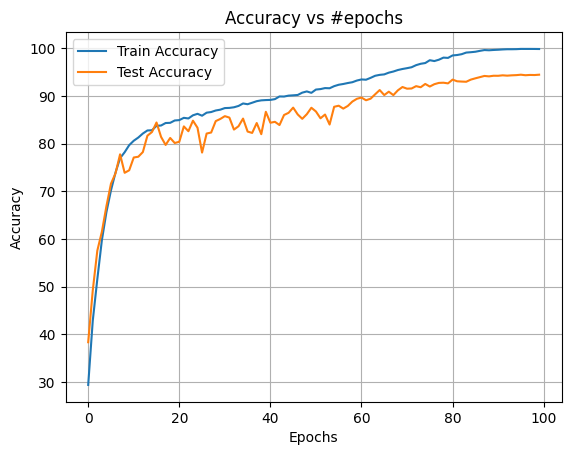

In [47]:
plot_test_accuracies(train_accuracies, test_accuracies)

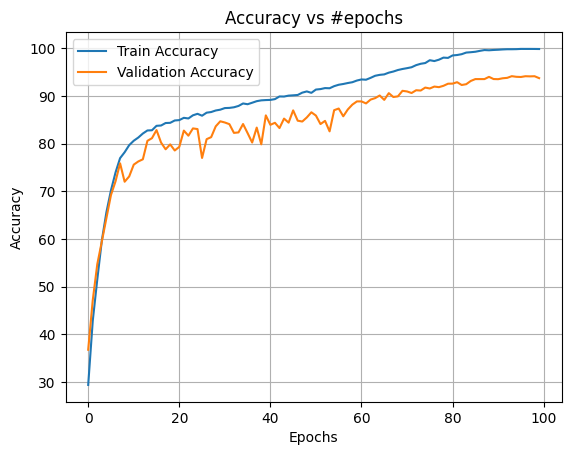

In [48]:
plot_val_accuracies(train_accuracies, val_accuracies)

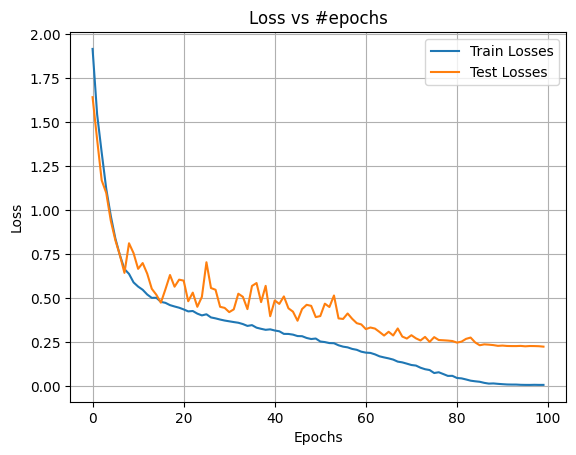

In [49]:
plot_test_losses(train_losses, test_losses)

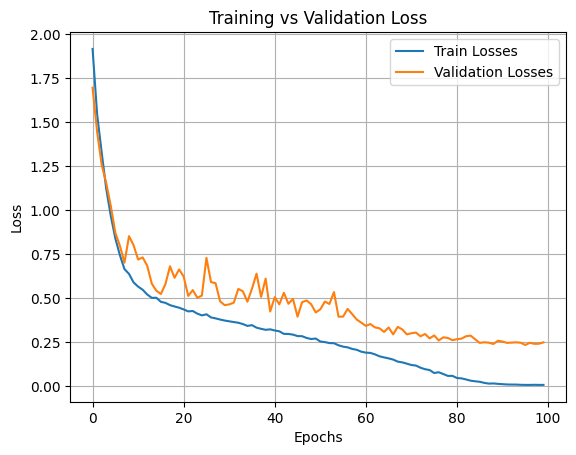

In [52]:
plot_val_losses(train_losses, val_losses)

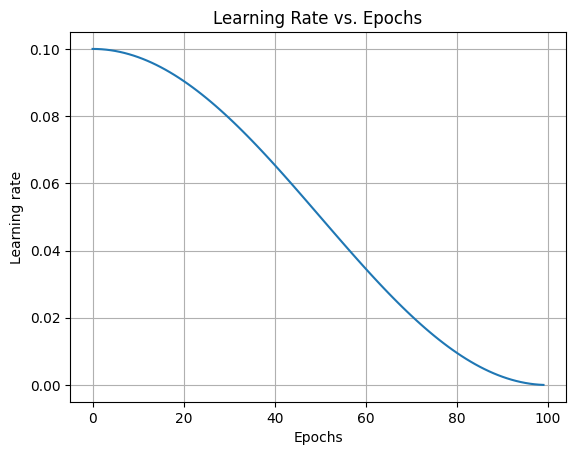

In [32]:
plot_lrs(train_lrs)

### Save the model

In [33]:
print('==> Saving final model...')
state = {
    'net': model.state_dict(),
    'acc': test_accuracies[-1],
    'epoch': number_of_epochs,
    'best_test_acc' : best_test_acc,
    'best_val_acc' : best_val_acc,
    'train_acc' : train_accuracies,
    'test_acc' : test_accuracies,
    'train_loss' : train_losses,
    'val_loss' : val_losses,
    'test_loss' : test_losses,
    'lr' : train_lrs
}
if not os.path.isdir('checkpoint'):
  os.mkdir('checkpoint')
torch.save(state, './checkpoint/rn_34_final.pth')

==> Saving final model...


## Make predictions for the given test dataset

dict_keys(['net', 'acc', 'epoch'])


<ipython-input-38-2be1fe9a3c44>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint/resnet_34_dropout_best.pth')


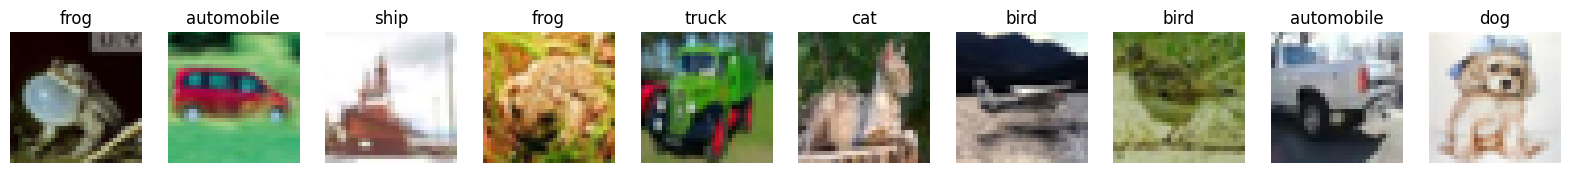

In [38]:
import numpy as np
import pickle
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

cifar10_dir = './data/cifar-10-batches-py'

# Load label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]  # Decode bytes to string

# Load given test data
test_batch = load_cifar_batch('/kaggle/input/nolabel/cifar_test_nolabel.pkl')
test_images = np.array(test_batch[b'data'])

data_stats = (
    (0.49139968, 0.48215827, 0.44653124),
    (0.24703233, 0.24348505, 0.26158768)
)

# transformation for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_stats, inplace=True)
])

# Apply transformations to test images
augmented_test_images = torch.stack([transform(image) for image in test_images])

# Create a dataset from test images
test_dataset = TensorDataset(augmented_test_images)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2, pin_memory=True)

# Load the trained model
model = ResNet34()

checkpoint = torch.load('./checkpoint/rn_34_best.pth')

# Check keys in the checkpoint dictionary
print(checkpoint.keys())

# Assuming the model state dictionary is saved under a different key
# Adjust this according to the actual key in your checkpoint file
model.load_state_dict(checkpoint['net'])

model = model.to(device)
augmented_test_images = augmented_test_images.to(device)

# Evaluate the model on test data
model.eval()

predictions = []

# Process in batches
with torch.no_grad():
    for batch in test_loader:
        batch = batch[0].to(device)  # Move batch to GPU
        outputs = model(batch)  # Forward pass
        _, batch_preds = torch.max(outputs, 1)  # Get predicted class
        predictions.extend(batch_preds.cpu().numpy())  # Move predictions to CPU

# Convert predictions to a NumPy array
predicted = np.array(predictions)

# Display the first 10 test images and predicted labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i])
    plt.title(label_names[predicted[i].item()])
    plt.axis('off')
plt.show()

# Save the output in csv containing ID, Labels
output_data = {'ID': np.arange(len(predicted)), 'Labels': predicted}
output_df = pd.DataFrame(output_data)
output_df.to_csv('rn_34_output.csv', index=False)

### Visualizing the predictions

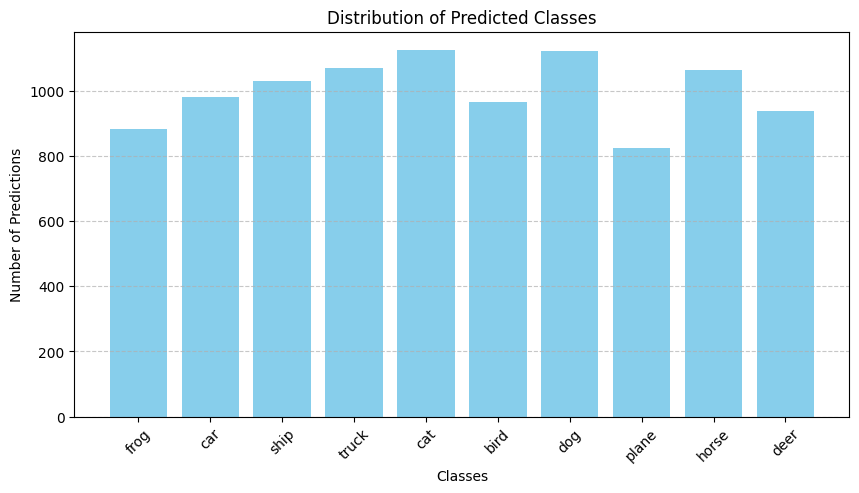

In [40]:
import matplotlib.pyplot as plt
from collections import Counter

# Convert counts to a list for visualization
class_counts = Counter(predicted)

# Sort labels in CIFAR-10 order
sorted_classes = [classes[i] for i in class_counts.keys()]
sorted_counts = [class_counts[i] for i in class_counts.keys()]

plt.figure(figsize=(10,5))
plt.bar(sorted_classes, sorted_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Predicted Classes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [41]:
from collections import Counter

class_counts = Counter(predicted)

# Print counts for each class
for class_idx, count in class_counts.items():
    print(f"{classes[class_idx]}: {count}")


frog: 883
car: 981
ship: 1029
truck: 1069
cat: 1125
bird: 966
dog: 1121
plane: 824
horse: 1064
deer: 938
